In [1]:
# add autoreload
%load_ext autoreload
%autoreload 2
import os
import sys
import json

import numpy as np
import pandas as pd
import scipy as sc

from collections import defaultdict
import re
import deduce

from tqdm import tqdm
import seaborn as sns

from gensim.models import phrases

import matplotlib.pyplot as plt

import dill

# Context:
* $100$ K echocardiographic reports available. 
* we want to extract diagnoses regarding the left-ventricle function
* we have $5000$ reports with labeled spans.

# Goal:
Train a "model" that can
1. identify the spans
2. classify the spans

# Approach: MedCAT - MetaCAT

## Two-step approach

* unsupervised training on the documents
* add a single custom entity with a custom identifier
* train a model to identify the custom entities
* supervised training on the meta-annotations of the entities

## One-step approach

* unsupervised training on the documents
* add custom entities based on the spans and their labels
* train a model to identify the custom entities

# Approach: biLSTM/transformer

## Two-step approach

* Train a model to identify the spans: self-supervision by random selecting non-span ranges as negative examples
* Train a model to classify the spans: supervised based on the labeled spans 
* Combine the model in one pipeline

## One-step approach
* Assign a label to each span
* Train a model to identify the spans

##  Load Medcat modelpack

In [2]:
# load dotenv
from dotenv import load_dotenv
load_dotenv('../.env')
# extract the environment variable 'medcat_pack'


True

In [3]:
from medcat.cat import CAT
from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.config import Config
from medcat.meta_cat import MetaCAT

d:\VENVS\Envs\nlp_310\lib\site-packages\medcat\cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [11]:
base_medcat_path = os.getenv('medcat_pack')
pack_location = 'umls-dutch-v1-10_echo'
prep_medcat = False

# Load texts

In [4]:
echo_path = 'T://lab_research/RES-Folder-UPOD/Echo_label/E_ResearchData/2_ResearchData'
# load the jsonl in a dataframe
texts = pd.read_json(os.path.join(echo_path, 'outdb_140423.jsonl'), lines=True)
#texts_zipped = zip(texts['text'], texts['_input_hash'], texts['_task_hash'])

# Load train/test splits

In [5]:
train_indcs = pd.read_csv(os.path.join(echo_path, 'train_echoid.csv'), sep=',')
test_indcs = pd.read_csv(os.path.join(echo_path, 'test_echoid.csv'), sep=',')

train_indcs = train_indcs[train_indcs.input_hash.notna()]
test_indcs = test_indcs[test_indcs.input_hash.notna()]

In [6]:
TRAIN_INPUT_HASH = set(train_indcs['input_hash'].astype(int).to_list())
TRAIN_TASK_HASH = set(train_indcs['task_hash'].astype(int).to_list())

TEST_INPUT_HASH = set(test_indcs['input_hash'].astype(int).to_list())
TEST_TASK_HASH = set(test_indcs['task_hash'].astype(int).to_list())

In [7]:
texts_train = texts.loc[texts._input_hash.isin(TRAIN_INPUT_HASH)]
texts_test = texts.loc[texts._input_hash.isin(TEST_INPUT_HASH)]

## Make splitted data

* MedCAT train files
* class-dictionary with dataframes

In [25]:
def get_medcat_json(filename: str=None, HashSet: set=False, ClassName: str=None):
    texts = pd.read_json(filename, lines=True)
    output = {"projects": [{
                "name": ClassName,
                "id": 42,
                "cuis": "",
                "tuis": "",
                "documents": None
            }]}
    
    documents = []
    for i, _row in enumerate(texts.iterrows()):
        row = _row[1]
        if (row["_input_hash"] in HashSet) | (HashSet is False):
            txt = row['text']
            id = i
            input_hash = row["_input_hash"]
            task_hash = row["_task_hash"]
            annotations = []
            for j, ann in enumerate(row["spans"]):
                res = {}
                res['user'] = 'BVE'
                res['cui'] = 123
                res['id'] = j
                res['start'] = ann['start']
                res['end'] = ann['end']
                res['value'] = txt[ann['start']:ann['end']]
                res['validated'] = True
                res['correct'] = True
                res['deleted'] = False
                res['alternative'] = False
                res['killed'] = False
                res["meta_anns"] = {
                    ClassName: {
                        "name": ClassName,
                        "validated": True,
                        "accuracy": 1.0,
                        "value": ann['label']
                    }
                }
                annotations.append(res)
            doc = {
                'id': id,
                'text': txt,
                'input_hash': input_hash,
                'task_hash': task_hash,
                'annotations': annotations         
            }
            documents.append(doc)
    output['projects'][0]['documents'] = documents
    
    return output


In [26]:
class_names = os.listdir(os.path.join(echo_path, 'echo_span_labels'))
merged_index = [i for i,t in enumerate(class_names) 
                    if ('merged' in t) | ('old' in t)]
merged_index = sorted(merged_index, reverse=True)

for mind in merged_index:
    class_names.pop(mind)
class_ds = defaultdict(dict)

for file_name in class_names:
    _class = file_name.split(".")[0]
    fn = os.path.join(echo_path, 'echo_span_labels', file_name)
    class_ds[_class]['ds'] = pd.read_json(fn, lines=True)
    
    #TODO: has to be refactored
    medcat_json = get_medcat_json(fn, TRAIN_INPUT_HASH, _class)
    medcat_out = os.path.join(echo_path, 'medcat_labels', 'train', f'medcat_{_class}.json')
    json.dump(medcat_json, open(medcat_out, 'w'))
    class_ds[_class]['train_location'] = medcat_out
    
    medcat_json = get_medcat_json(fn, TEST_INPUT_HASH, _class)
    medcat_out = os.path.join(echo_path, 'medcat_labels', 'test', f'medcat_{_class}.json')
    json.dump(medcat_json, open(medcat_out, 'w'))
    class_ds[_class]['test_location'] = medcat_out
    
    class_ds[_class]['labels'] = set([span_dict['label'] 
                                        for span_list in class_ds[_class]['ds']['spans'].tolist()
                                        for span_dict in span_list])


## Unsupervised learning for NER+L

In [ ]:
MCAT = CAT.load_model_pack(os.path.join(base_medcat_path, pack_location))

MCAT.train(texts_train.text.values, 
            nepochs=3, 
            progress_print=10,  
            is_resumed=True)
MCAT.create_model_pack(base_medcat_path + "/umls-dutch-v1-10_echo")

### Add label spans from Prodigy annotations

In [27]:
span_sets = defaultdict(set)
for _class, dsd in tqdm(class_ds.items()):
        ds = dsd['ds']
        span_set = set()
        span_list = []
        ds = ds[ds._input_hash.isin(TRAIN_INPUT_HASH)]
        for k, (_spans, text) in enumerate(zip(ds[ds.spans.notna()].spans.values,
                                            ds[ds.spans.notna()].text.values)):
            for _span in _spans:
                start, end = _span['start'], _span['end']
                span_set.add(text[start:end])
                span_list.append(text[start:end])
        span_sets[_class] = span_set

100%|██████████| 11/11 [00:00<00:00, 22.18it/s]


In [ ]:
# TODO: interesting to add variants without the abbreviations?
# TODO: including paraphrasing?

In [ ]:
for _class, span_set in tqdm(span_sets.items()):
    for _span in span_set:
        MCAT.add_and_train_concept(cui=_class,
                                name=_span, 
                                do_add_concept=True,
                                negative=False,
                            )

## Supervised learning for NER+L

In [ ]:
MCAT.train_supervised(data_path=os.path.join(base_medcat_path, 
                                 "umls-dutch-v1-10_echo",
                                 "input/ner_l_anno/trainer_export.json"), 
                      nepochs=4,
                      print_stats=0,
                      use_filters=False)
medcat_path = base_medcat_path + "/umls-dutch-v1-10_echoV2"
MCAT.create_model_pack(medcat_path)

## Supervised learning of MetaCAT models

In [12]:
# load MCAT from file
medcat_path = os.path.join(base_medcat_path, 'umls-dutch-v1-10_echoV2')

In [ ]:
MCAT = CAT.load_model_pack(medcat_path)

In [9]:
from medcat.meta_cat import MetaCAT
from medcat.config_meta_cat import ConfigMetaCAT
from medcat.tokenizers.meta_cat_tokenizers import TokenizerWrapperBPE, ByteLevelBPETokenizer

In [ ]:
# load tokenizer from negation_model
# tokenizer folder 
tok_folder = 'T:/laupodteam/AIOS/Bram/language_modeling/Clinical_embeddings/bigrams/with_tokenizer/v2/tokenizer'
emb_folder = 'T:/laupodteam/AIOS/Bram/language_modeling/Clinical_embeddings/bigrams/with_tokenizer/v2/SG'
tokenizer = ByteLevelBPETokenizer.from_file(os.path.join(tok_folder, 'vocab.json'), 
                                            os.path.join(tok_folder, 'merges.txt'))
wrapped_tokenizer = TokenizerWrapperBPE(hf_tokenizers=tokenizer)
wrapped_tokenizer.save(medcat_path + "/assets/tokenizer")

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
vec_path = os.path.join(emb_folder, 'sg')
print(vec_path)
w2v = KeyedVectors.load(vec_path)

In [ ]:
# Create embedding matrix
embeddings = []
words_not_present = []

for i in range(tokenizer.get_vocab_size()):
    word = tokenizer.id_to_token(i)
    if word in w2v:
        embeddings.append(w2v[word])
    else:
        words_not_present.append(i)
        embeddings.append(np.random.random(300))
        
mean_vector = np.mean(embeddings, axis=0)

for i in words_not_present:
    embeddings[i] = mean_vector

# Save the embeddings
embeddings_array = np.array(embeddings)
np.save(open(medcat_path+"/assets/embeddings/embedding.npy", 
             'wb'), embeddings_array)

print(f"Words not present:{len(words_not_present)}")

In [ ]:
for _class, d in class_ds.items():
    if _class != 'normal':
        print(f"Commencing training of biLSTM-span for {_class}...")
        config_metacat = ConfigMetaCAT()
        config_metacat.general['category_name'] = _class
        config_metacat.train['nepochs'] = 25
        config_metacat.train['score_average'] = 'weighted'
        config_metacat.model['hidden_size'] = 256
        config_metacat.model['input_size'] = 300
        config_metacat.model['dropout'] = 0.3
        config_metacat.model['num_layers'] = 3
        config_metacat.model['num_directions'] = 2
        config_metacat.model['nclasses'] = len(d['labels'])
        config_metacat.model['model_name'] = 'lstm'
        
        meta_cat = MetaCAT(tokenizer=wrapped_tokenizer,
                    embeddings=embeddings_array, 
                    config=config_metacat)
        
        train_path = d['train_location']
        model_path = os.path.join(medcat_path, f"meta_{_class}")
        os.makedirs(model_path, exist_ok=True)
        
        meta_cat.train(json_path=train_path, 
                        save_dir_path=model_path)
        
        meta_cat.save(save_dir_path=model_path)
        # now manually add the model to the model_pack...
        label_dict = config_metacat.general.category_value2id
        
        # add to config
        medcat_config = json.load(open(os.path.join(medcat_path, 'model_card.json'), 'r'))
        
        # add to "MetaCAT models" list
        medcat_config["MetaCAT models"].append({
                      "Category Name": _class,
                      "Description": "No description",
                      "Classes": label_dict,
                        "Model": "lstm"
                    })
        # write config to .json
        json.dump(medcat_config, open(os.path.join(medcat_path, 'model_card.json'), 'w'))

## Load  new model pack

In [13]:
MCATnew = CAT.load_model_pack(os.path.join(medcat_path))

d:\VENVS\Envs\nlp_310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'nl_core_news_lg' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Apply to texts

In [14]:
from spacy import displacy

In [19]:
i = 123
doc = MCATnew(texts.text.values[i])
displacy.render(doc, style='ent')

In [20]:
def create_dict_with_conf(ent):
    result_dict = {}
    for k, v in ent._.meta_anns.items():
        result_dict[k] = v['value']
        result_dict[f'conf_{k}'] = v['confidence']
    return result_dict

In [21]:
doc = MCATnew(texts.text.values[i])
inds = []
res = []
for ent in doc.ents:
    inds.append(ent.text)
    res.append(create_dict_with_conf(ent))
    
res_df = pd.DataFrame(res, index=inds)

In [22]:
res_df.c

,aortic_regurgitation,conf_aortic_regurgitation,aortic_stenosis,conf_aortic_stenosis,diastolic_dysfunction,conf_diastolic_dysfunction,lv_dil,conf_lv_dil,lv_syst_func,conf_lv_syst_func,...,pe,conf_pe,rv_dil,conf_rv_dil,rv_syst_func,conf_rv_syst_func,tricuspid_regurgitation,conf_tricuspid_regurgitation,wma,conf_wma
L.V. is niet vergroot,aortic_valve_native_regurgitation_not_present,0.981397,aortic_valve_native_stenosis_not_present,0.987066,lv_dias_func_normal,0.927207,lv_dil_normal,0.694518,lv_sys_func_mild,0.504134,...,pe_not_present,0.822488,rv_dil_normal,0.999218,rv_sys_func_mild,0.807520,tricuspid_valve_native_regurgitation_not_present,0.877692,wma_present,0.980276
LVH,aortic_valve_native_regurgitation_not_present,0.999951,aortic_valve_native_stenosis_sclerosis,0.667423,lv_dias_func_mild,0.471018,lv_dil_normal,0.838429,lv_sys_func_normal,0.981571,...,pe_not_present,0.992050,rv_dil_normal,0.998393,rv_sys_func_normal,0.993181,tricuspid_valve_native_regurgitation_not_present,0.673197,wma_present,0.926663
Goede R.V. functie.,aortic_valve_native_regurgitation_not_present,0.999994,aortic_valve_native_stenosis_not_present,0.999920,lv_dias_func_normal,0.999206,lv_dil_normal,0.999795,lv_sys_func_normal,0.999352,...,pe_not_present,0.999676,rv_dil_present,0.989306,rv_sys_func_normal,0.999907,tricuspid_valve_native_regurgitation_trace,0.509716,wma_not_present,0.664993


## Evaluate

In [136]:
TEST_RESULTS = {}
for k in class_ds.keys():
    if k != 'normal':
        CATmodel = MetaCAT.load(os.path.join(medcat_path, f'meta_{k}'))
        CATmodel.config['train']['score_average'] = 'macro'
        test_location = class_ds[k]['test_location']
        test_labels = json.load(open(test_location, 'r'))
        bulk_res = CATmodel.eval(test_location)
        
        res_count = defaultdict(int)
        for doc in test_labels['projects'][0]['documents']:
            anns = doc['annotations']
            if len(anns)>0:
                for ann in anns:            
                    _ann = ann['meta_anns'][k]
                    res_count[_ann['value']] += 1

        TEST_RESULTS[k] = {
            'f1':  bulk_res['f1'],
            'precision': bulk_res['precision'],
            'recall': bulk_res['recall'],
            'confusion_df': bulk_res['confusion matrix'],
            'real_presence': res_count
        }

d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classif

In [132]:
TEST_RESULTS.keys()

dict_keys(['aortic_regurgitation', 'aortic_stenosis', 'diastolic_dysfunction', 'lv_dil', 'lv_syst_func', 'mitral_regurgitation', 'pe', 'rv_dil', 'rv_syst_func', 'tricuspid_regurgitation', 'wma'])

In [148]:
TEST_RESULTS['wma']

{'f1': 0.9744575936883628,
 'precision': 0.9769993390614673,
 'recall': 0.9720695970695972,
 'confusion_df':                            true wma_not_present  true wma_present
 predicted wma_not_present                    87                 4
 predicted wma_present                         2               166,
 'real_presence': defaultdict(int,
             {'wma_not_present': 91, 'wma_present': 168})}

In [ ]:
dill.dump(TEST_RESULTS, file=open("../artifacts/MetaCAT_test_results.pkl", "wb"))
#TEST_RESULTS = dill.load(open("../artifacts/MetaCAT_test_results.pkl", "rb"))

## Assessment of performance in the wild

In [56]:
merged_labels_train = get_medcat_json(open(os.path.join(echo_path, 'echo_span_labels', 'merged_labels.jsonl'), 'r'), 
                                    TRAIN_INPUT_HASH, 'merged')['projects'][0]['documents']

merged_labels_test = get_medcat_json(open(os.path.join(echo_path, 'echo_span_labels', 'merged_labels.jsonl'), 'r'), 
                                    TEST_INPUT_HASH, 'merged')['projects'][0]['documents']

In [57]:
comparison_list = []
for medcat_doc in tqdm(merged_labels_test):
    txt = medcat_doc['text']
    parsed_doc = MCATnew(txt)

    res = []
    start_stop = []
    for ent in parsed_doc.ents:
        start_stop.append((ent.start_char, ent.end_char))
        res.append(create_dict_with_conf(ent))
    
    medcat_doc['predicted'] = {k:v for k,v in zip(start_stop, res)}
    comparison_list.append(medcat_doc)
comparison_list_with_annotations_present = [d for d in comparison_list if len(d['annotations'])>0]

100%|██████████| 991/991 [03:25<00:00,  4.83it/s]


In [58]:
def get_pred_list(pred_dict: dict=None):
    return [v for k,v in pred_dict.items() if 'conf_' not in k]
    
span_suggester_comparison_list = []
for d in tqdm(comparison_list_with_annotations_present):
    anns = d['annotations']
    span_cat_list = []
    for ann in anns:
        span = (ann['start'], ann['end'])
        class_val = ann['meta_anns']['merged']['value']
        span_cat_list.append((span, class_val))
    
    pred_list = []
    for k, pred in d['predicted'].items():
        pred_list.append((k, get_pred_list(pred)))
    
    span_suggester_comparison_list.append([span_cat_list, pred_list])

100%|██████████| 952/952 [00:00<00:00, 47601.18it/s]


In [81]:
# We want to get the coverage of spans -> a count of all (partially) overlapping spans
# We want to get the token overlap of covered spans (Jaccard?)
# span overlap count

def _tuple_overlap(tL, tR):
    # tL: tuple(begin, end)
    # tR: tuple(begin, end)
    tLrange = set(range(*tL))
    tRrange = set(range(*tR))
               
    InterSection = len(tLrange.intersection(tRrange))
    Union = len(tLrange.union(tRrange))
    
    return InterSection/Union if Union>0 else np.nan

def span_overlap_counter(labeled_spans):
    # label_spans: list[[list[((begin,end), label)], list[((begin,end), [labels])]]]
    OverlapList = []
    for span_labs in labeled_spans:
        span_set_medcat = set()
        span_set_labeled = set()
        for lab_span in span_labs[0]:
            span_set_labeled.add(lab_span[0])
        
        for med_span in span_labs[1]:
            span_set_medcat.add(med_span[0])
        
        # check overlap
        jaccard_indices = []
        for spanLab in span_set_labeled:
            _jaccard_indices = []            
            for spanMedcat in span_set_medcat:
                _jaccard_indices.append(_tuple_overlap(spanLab, spanMedcat))
            try:
                max_ = max(_jaccard_indices)
            except:
                max_ = np.nan
            jaccard_indices.append(max_)
        OverlapList.append(jaccard_indices)
    return OverlapList

def span_overlap_counter_with_assignment(labeled_spans):
    # label_spans: list[[list[((begin,end), label)], list[((begin,end), [labels])]]]
    OverlapList = []
    for span_labs in labeled_spans:
        span_set_medcat = set()
        span_dict_labeled = defaultdict(set)
        for lab_span in span_labs[0]:
            span_dict_labeled[lab_span[1]].add(lab_span[0])
        
        for med_span in span_labs[1]:
            span_set_medcat.add(med_span[0])
        
        # check overlap
        jaccard_indices = defaultdict(list)
        for spanClass, spanLabs in span_dict_labeled.items():
            for spanLab in spanLabs:                         
                _jaccard_indices = []   
                for spanMedcat in span_set_medcat:
                    _jaccard_indices.append(_tuple_overlap(spanLab, spanMedcat))
                try:
                    max_ = max(_jaccard_indices)
                except:
                    max_ = np.nan
                jaccard_indices[spanClass].append(max_)
        OverlapList.append(jaccard_indices)
    return OverlapList
    

In [73]:
OverlapJaccardIndices = span_overlap_counter(span_suggester_comparison_list)
OverlapJaccardClassIndices = span_overlap_counter_with_assignment(span_suggester_comparison_list)

In [96]:
PerClassValueJaccard = defaultdict(list)
for d in OverlapJaccardClassIndices:
    for k,v in d.items():
        PerClassValueJaccard[k].extend(v)

In [115]:
ClassMap = defaultdict(dict)
for k, v in class_ds.items():
    for lab in v['labels']:
        ClassMap[lab] = k
ClassMap['normal'] = 'normal'

In [122]:
PerClassJaccard = defaultdict(list)
for cv, v in PerClassValueJaccard.items():
    PerClassJaccard[ClassMap[cv]].extend(v)

Mean document coverage: nan, with 0.6787009164851803 over all tokens


C:\Users\bes3\AppData\Local\Temp\ipykernel_3528\1556285475.py:1: RuntimeWarning: Mean of empty slice
  MeanPerDocument = [np.nanmean(v) for v in OverlapJaccardIndices]


Text(0.5, 1.0, 'Span overlap per document')

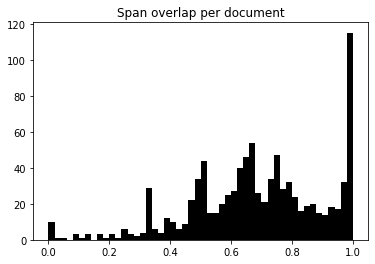

In [76]:
MeanPerDocument = [np.nanmean(v) for v in OverlapJaccardIndices]
MeanOverall = np.nanmean([_v for v in OverlapJaccardIndices for _v in v])

print(f"Mean document coverage: {np.mean(MeanPerDocument)}, with {MeanOverall} over all tokens")

plt.hist(MeanPerDocument, bins=50, color='black');
plt.title("Span overlap per document")

In [125]:
[{'class': k, 'mean': np.nanmean(v)} for k,v in PerClassJaccard.items()]

[{'class': 'tricuspid_regurgitation', 'mean': 0.5742186400510773},
 {'class': 'rv_syst_func', 'mean': 0.7643220714162753},
 {'class': 'lv_syst_func', 'mean': 0.725442260486021},
 {'class': 'aortic_regurgitation', 'mean': 0.5664092419919264},
 {'class': 'mitral_regurgitation', 'mean': 0.6506049489112156},
 {'class': 'aortic_stenosis', 'mean': 0.4801191183820977},
 {'class': 'lv_dil', 'mean': 0.4622994060566221},
 {'class': 'rv_dil', 'mean': 0.30486922540091316},
 {'class': 'normal', 'mean': 0.532194941490294},
 {'class': 'pe', 'mean': 0.7936107123597836},
 {'class': 'diastolic_dysfunction', 'mean': 0.8023843251543331},
 {'class': 'wma', 'mean': 0.5501622715158951}]

In [62]:
MinMean = 0.25
CheckRes = [{'Jaccard': v, 
             'res': comparison_list_with_annotations_present[i]} 
            for i,v in enumerate(OverlapJaccardIndices)
            if (np.mean(v)<MinMean) | (np.isnan(np.mean(v)))]

In [63]:
print(f"We have {len(CheckRes)} documents to check")

We have 42 documents to check


In [111]:
CheckRes[0]['res']['predicted']

{(39,
  63): {'aortic_regurgitation': 'aortic_valve_native_regurgitation_not_present', 'conf_aortic_regurgitation': 0.9999958276748657, 'aortic_stenosis': 'aortic_valve_native_stenosis_not_present', 'conf_aortic_stenosis': 0.9999805688858032, 'diastolic_dysfunction': 'lv_dias_func_normal', 'conf_diastolic_dysfunction': 0.9995680451393127, 'lv_dil': 'lv_dil_normal', 'conf_lv_dil': 0.9998514652252197, 'lv_syst_func': 'lv_sys_func_normal', 'conf_lv_syst_func': 0.9994962215423584, 'mitral_regurgitation': 'mitral_valve_native_regurgitation_not_present', 'conf_mitral_regurgitation': 0.9999899864196777, 'Negation': 'not negated', 'conf_Negation': 0.9992412328720093, 'pe': 'pe_not_present', 'conf_pe': 0.999327540397644, 'rv_dil': 'rv_dil_normal', 'conf_rv_dil': 0.9999010562896729, 'rv_syst_func': 'rv_sys_func_normal', 'conf_rv_syst_func': 0.9978834986686707, 'tricuspid_regurgitation': 'tricuspid_valve_native_regurgitation_not_present', 'conf_tricuspid_regurgitation': 0.9991766810417175, 'wma':

In [ ]:
# TODO: check maximum length of the spans detected with MedCAT.